# CNN
This notebook aims to deploy the CNN.

## Setup for UCloud
The Setup on Ucloud is a bit feasty at times, so here are some workarounds

In [1]:
#pip freeze > requirements.txt

In [2]:
# !pip install -r requirements.txt
# !pip install matplotlib opencv-python pandas scikit-learn tensorflow
# !pip install numpy==1.26.4 --force-reinstall
# !pip install editdistance

# # scipy
# !pip install --upgrade --force-reinstall --no-cache-dir scipy
# !pip install --upgrade --force-reinstall --no-cache-dir scikit-learn


In [3]:
# sudo apt update && sudo apt install -y libgl1

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
from sklearn.model_selection import train_test_split
from editdistance import eval as edit_distance  

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from tensorflow.keras.backend import ctc_decode



2025-05-19 16:23:56.209283: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-19 16:23:56.394961: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-19 16:23:56.583474: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747664636.770894   74339 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747664636.815800   74339 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747664637.058523   74339 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

---
## Loading the data
Data has to load out of the 'carolianminuscule-groundtruth'-folder 

In [5]:
def get_images(folder_path: str):
    """
    Load images and text files from the given path.
    :param folder_path: Path to the directory containing images and text files.
    :return: Two lists - one for image paths and one for text file paths.
    """
    if not os.path.exists(folder_path):
        raise FileNotFoundError(f"Path {folder_path} does not exist.")

    images = []
    files = []

    for entry in os.listdir(folder_path):
        entry_path = os.path.join(folder_path, entry)
        if os.path.isdir(entry_path):
            # Recursively get images and text files from subdirectories
            sub_images, sub_files = get_images(entry_path)
            images.extend(sub_images)
            files.extend(sub_files)
        elif entry.endswith(".png"):
            images.append(entry_path)
        elif entry.endswith(".txt"):
            files.append(entry_path)

    return images, files


# load the data from the directory
path = "carolineminuscule-groundtruth"
images, files = get_images(path)


# matched the .png- and .txt-file in a folder together
matched_list_path = [
    [img, file]
    for img in images
    for file in files
    if os.path.dirname(img) == os.path.dirname(file)
    and os.path.splitext(os.path.splitext(os.path.basename(img))[0])[0]
    == os.path.splitext(os.path.splitext(os.path.basename(file))[0])[0]
]


In [6]:
print(f"len matched: {len(matched_list_path)}")
print(f"matched_list:\n {matched_list_path[1]}")

len matched: 429
matched_list:
 ['carolineminuscule-groundtruth/bsb00095929/0011/010002.bin.png', 'carolineminuscule-groundtruth/bsb00095929/0011/010002.gt.txt']


---
## Creating the Dataset

In [7]:
# define a dataframe to store the image, image paths and their corresponding text files
df = pd.DataFrame(columns=["name", "image", "transcription"])

for i, (img_path, file_path) in enumerate(matched_list_path):
    # read the image
    img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
    img = np.array(img)
    # add the image to the dataframe, set "none" here to add transcription later
    df.loc[i] = [os.path.basename(img_path), img, None]
    # read the text file
    with open(file_path, "r") as f:
        # read the transcription
        transcription = f.read()
    # add the transcription to the dataframe
    df.loc[i, "transcription"] = transcription

In [8]:
# delete all the linebrakes in the transcription
df["transcription"] = df["transcription"].str.replace("\n", "", regex=False)
df.head(5)

,name,image,transcription
0,010005.bin.png,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",initio sicuti pleriq; studio ad empabacan
1,010002.bin.png,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",gla memores que s quis: faciliafacto putat
2,010007.bin.png,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",pro abstinentia ꝓuirtute audacia. largitio. au...
3,010008.bin.png,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",bant. Quę tametsianimus aspꝑnabatur. insolens ...
4,010017.bin.png,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",tilinę coniuratione quam uerissime potero paucis


For now it appear that the images only have "255" as values, i.e. white. That's why im checking for other values. But the edges of the images are all white, therefore this is the exspected behaviour.

In [9]:
non_255_values = df['image'].apply(lambda img: np.any(img != 255))
print(f"Rows  in 'image' with values other than 255: {non_255_values.sum()}")

Rows  in 'image' with values other than 255: 429


---
## Preparing the data

By calculating the maximum and avg. number of the height we can use that value later in our CNN.

In [10]:
# Calculate the maximum and average length of the lists in the 'image' column
image_heigth = df['image'].apply(lambda img: img.shape[0])  # Get the height of each image array
max_length = image_heigth.max()
avg_length = image_heigth.mean()

print(f"Maximum height of an image: {max_length}")
print(f"Average height of an image: {int(avg_length)}")


# Calculate the maximum and average length of the lists in the 'image' column
image_lengths = df['image'].apply(lambda img: img.shape[1])  # Get the height of each image array
max_length = image_lengths.max()
avg_length = image_lengths.mean()

print(f"Maximum length of an image: {int(max_length)}")
print(f"Average length of an image: {int(avg_length)}")

Maximum height of an image: 263
Average height of an image: 140
Maximum length of an image: 3058
Average length of an image: 1938


Getting the number of unique character, servs here more as an exploration into the the datas.
We stand at a pathway here: Either we manually map each of the 83 characters by hand to the according representative in the images or, use the CNN-RNN architecture. Which does not need manual character mapping, but is harder to train.

In [11]:
# Features (images) and labels (transcriptions)
X = df["image"].values  # Images as NumPy arrays
y = df["transcription"].values  # Transcriptions as strings

In [12]:
# # Convert images to NumPy arrays and normalize
X = np.array(
    [cv2.resize(img, (128, 256)) for img in df["image"]], dtype=np.float32
)  # Resize and convert to float32

print(f"X shape: {X.shape}, dtype: {X.dtype}")

X shape: (429, 256, 128), dtype: float32


In [13]:
# find the length of the transcription
# aplly different measures

transcription_lengths = df["transcription"].apply(len)
print("Transcription lengths:")
print(f"Max length:\t\t {int(transcription_lengths.max())}")
print(f"Mean length:\t\t {int(transcription_lengths.mean())}")
print(f"Median length:\t\t {int(transcription_lengths.median())}")

Transcription lengths:
Max length:		 70
Mean length:		 46
Median length:		 48


In [14]:
# Create a character-to-index mapping
charset = sorted(set("".join(df["transcription"])))  # Unique characters in the dataset
char_to_index = {char: idx for idx, char in enumerate(charset)}
index_to_char = {idx: char for char, idx in char_to_index.items()}
num_classes = len(charset) + 1  # Add 1 for the blank character (CTC loss)


# Convert transcriptions to sequences of integers
label_sequences = [
    [char_to_index[char] for char in transcription]
    for transcription in df["transcription"]
]

# Pad sequences to a fixed length
max_sequence_length = 256  # slightly larger than the max length

# Pad sequences to a fixed length
padded_labels = pad_sequences(
    label_sequences, maxlen=max_sequence_length, padding="post", value=num_classes - 1
)


print(f"y shape: {y.shape}, dtype: {y.dtype}")

y shape: (429,), dtype: object


In [15]:
# Convert transcriptions to sequences of integers
label_sequences = [
    [char_to_index[char] for char in transcription]
    for transcription in df["transcription"]
]

# Pad sequences to a fixed length (use a value outside the valid character indices, like num_classes - 1 for blank)
padded_labels = pad_sequences(
    label_sequences, maxlen=max_sequence_length, padding="post", value=num_classes - 1
)


# Convert padded labels to one-hot encoding
y = np.array(padded_labels, dtype=np.int32)


In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

num_classes = len(charset) + 1  # Number of unique characters

In [17]:
print(f"X_train shape: {X_train.shape}, dtype: {X_train.dtype}")
print(f"y_train shape: {y_train.shape}, dtype: {y_train.dtype}")

X_train shape: (343, 256, 128), dtype: float32
y_train shape: (343, 256), dtype: int32


---
## Data visualisation
Below I want to gain a better understanding of our datapoints

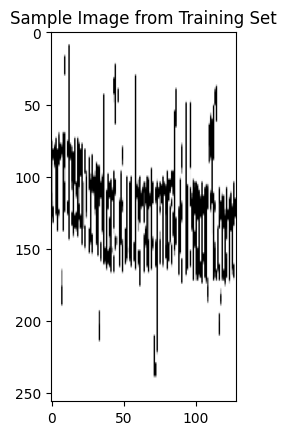

In [18]:
plt.imshow(X_train[10], cmap="gray", vmin=0, vmax=255)
plt.title("Sample Image from Training Set")
plt.show()

In [19]:
print("First entry in y_train:")
print(y_train[10])

First entry in y_train:
[42 36  0 45  3 35 40 34 32 49 40 44  0 34 44 42 45 41 36 32 49  3  5  0
 36 49  0 32 50 35 40 47 36 43 49  0 38 36 43 49 36 48  5  0 36 49  0 41
 40 33 36 47 32 49 50 48  0 48 71  0 36 52 44 47 36 83 83 83 83 83 83 83
 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83
 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83
 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83
 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83
 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83
 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83
 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83
 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83]


---

In [20]:
cnn_rnn = models.Sequential(
    [
        layers.Conv2D(
            64, (3, 3), padding="same", activation="relu", input_shape=(256, 128, 1)
        ),
        layers.MaxPooling2D(pool_size=(2, 2)),  # → (128, 64, 64)
        layers.Conv2D(128, (3, 3), padding="same", activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),  # → (64, 32, 128)
        layers.Reshape(target_shape=(64 * 32, 128)),  # → (2048, 128)
        layers.Bidirectional(layers.LSTM(256, return_sequences=True)),
        layers.Bidirectional(layers.LSTM(256, return_sequences=True)),
        layers.Dense(num_classes, activation="softmax"),
    ]
)


def ctc_loss(y_true, y_pred):
    input_length = (
        tf.ones(shape=(tf.shape(y_pred)[0], 1), dtype=tf.int32) * tf.shape(y_pred)[1]
    )
    label_length = (
        tf.ones(shape=(tf.shape(y_true)[0], 1), dtype=tf.int32) * tf.shape(y_true)[1]
    )
    return tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)


cnn_rnn.compile(optimizer="adam", loss=ctc_loss)

# cnn_rnn.summary()

/home/linus/Dokumente/1_Universitaet/10_SoSe_25/SPECIALIZATION-PROEJECT/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-05-19 16:24:02.978396: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [ ]:
#! Commented out to avoid running the model training
# # Fit the model
cnn_rnn.fit(
    X_train,
    y_train,
    epochs=1,
    validation_data=(X_test, y_test),
)

2025-05-19 16:24:08.985098: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 268435456 exceeds 10% of free system memory.
2025-05-19 16:24:09.129147: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 134217728 exceeds 10% of free system memory.
2025-05-19 16:24:13.220827: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 134217728 exceeds 10% of free system memory.
2025-05-19 16:24:13.264631: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 134217728 exceeds 10% of free system memory.
2025-05-19 16:24:13.314906: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 134217728 exceeds 10% of free system memory.


 1/11 ━━━━━━━━━━━━━━━━━━━━ 8:46 53s/step - loss: 8063.0332

In [ ]:
# # Vorhersagen erzeugen
# y_pred = cnn_rnn.predict(X_test)  # Shape: (batch_size, time_steps, num_classes)

# # Greedy decoding
# decoded, _ = ctc_decode(y_pred, input_length=np.ones(y_pred.shape[0]) * y_pred.shape[1])


# # In Text umwandeln
# def decode_to_text(seq):
#     return "".join(index_to_char.get(i, "") for i in seq if i < len(index_to_char))


# y_pred_texts = [decode_to_text(seq.numpy()) for seq in decoded[0]]
# y_true_texts = [
#     "".join(
#         [index_to_char[i] for i in np.argmax(label, axis=1) if i < len(index_to_char)]
#     )
#     for label in y_test
# ]

# # Character Error Rate (CER)
# total_chars = sum(len(t) for t in y_true_texts)
# total_errors = sum(edit_distance(p, t) for p, t in zip(y_pred_texts, y_true_texts))
# cer = total_errors / total_chars
# print(f"Character Error Rate (CER): {cer:.2%}")

In [ ]:
#cnn_rnn.save("./Run_models/CNN_RNN_model.keras")

In [ ]:
# # Load the model
# loaded_model = load_model("Run_models/20250519/20250519_CNN_RNN_model/")
# loaded_model.summary()


# # Select an image from the test set
# sample_image = X_test[0]

# # Reshape the image to match the input shape of the model
# sample_image_reshaped = sample_image.reshape(1, 256, 128, 1)

# # Get the model's prediction
# prediction = loaded_model.predict(sample_image_reshaped)

# decoded_sequences, _ = tf.keras.backend.ctc_decode(
#     prediction, input_length=np.ones(prediction.shape[0]) * prediction.shape[1]
# )
# predicted_text = "".join(
#     index_to_char[idx]
#     for idx in decoded_sequences[0][0].numpy()
#     if idx < num_classes - 1
# )

# # Decode the prediction
# predicted_sequence = np.argmax(prediction, axis=-1)[0]
# predicted_text = "".join(
#     index_to_char[idx] for idx in predicted_sequence if idx < num_classes - 1
# )

# print("Predicted transcription:")
# print(predicted_text)